# Expand Dataset with Additional Countries

Corruption thrives in environments with limited accountability, weak enforcement systems, and institutional weaknesses in governance structures. The World Bank's Worldwide Governance Indicators provide standardized measures of six key dimensions that capture these structural vulnerabilities: voice and accountability, political stability, government effectiveness, regulatory quality, rule of law, and control of corruption.

This notebook expands the baseline dataset from 3 countries to 19 countries, collecting governance indicators alongside complementary economic metrics across 2010-2023. The expanded dataset provides sufficient observations for machine learning model training while maintaining representation of diverse governance patterns, including documented corruption cases (Malaysia 1MDB scandal, Mozambique hidden debt crisis) and control countries with strong governance institutions.


In [75]:
import wbdata
import pandas as pd
import datetime
import os

# set working directory to project root
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    os.chdir('..')
elif 'notebooks' in current_dir:
    project_root = current_dir.split('notebooks')[0].rstrip('/')
    if os.path.exists(project_root):
        os.chdir(project_root)


## Country Selection

Countries are selected to represent diverse governance patterns, including documented corruption cases and control countries with strong governance institutions.


In [76]:
# baseline countries (already have data)
baseline_countries = {
    'CAN': 'Canada',
    'MYS': 'Malaysia',
    'MOZ': 'Mozambique'
}

# additional countries selected to represent diverse governance patterns
all_new_countries = {
    'AGO': 'Angola',
    'VEN': 'Venezuela',
    'ZWE': 'Zimbabwe',
    'IRQ': 'Iraq',
    'UKR': 'Ukraine',
    'BRA': 'Brazil',
    'ZAF': 'South Africa',
    'IND': 'India',
    'PHL': 'Philippines',
    'NOR': 'Norway',
    'DNK': 'Denmark',
    'SGP': 'Singapore',
    'AUS': 'Australia',
    'NZL': 'New Zealand',
    'CHE': 'Switzerland',
    'DEU': 'Germany'
}


## Indicator Definitions

We collect six governance indicators that measure institutional quality and accountability mechanisms, alongside five economic indicators that provide complementary context for financial vulnerability patterns.


In [77]:
# world bank indicator codes mapped to descriptive names
# governance indicators measure structural weaknesses that enable corruption
# economic indicators provide context for financial vulnerability patterns

indicators = {
    # six worldwide governance indicators (wgi)
    # these capture institutional quality and accountability mechanisms
    'VA.EST': 'Voice_Accountability',  # citizen participation and freedom of expression
    'PV.EST': 'Political_Stability',  # likelihood of political instability or violence
    'GE.EST': 'Government_Effectiveness',  # quality of public services and policy implementation
    'RQ.EST': 'Regulatory_Quality',  # ability to formulate and implement sound policies
    'RL.EST': 'Rule_of_Law',  # extent to which agents have confidence in and abide by rules
    'CC.EST': 'Control_of_Corruption',  # extent to which public power is exercised for private gain
    
    # economic indicators for contextual analysis
    # these help identify financial stress patterns associated with corruption
    'DT.DOD.DECT.GN.ZS': 'External_Debt_perc_GNI',  # external debt as percentage of gni
    'NY.GDP.MKTP.KD.ZG': 'GDP_Growth_annual_perc',  # annual gdp growth rate
    'GC.XPN.TOTL.GD.ZS': 'Govt_Expenditure_perc_GDP',  # government spending as percentage of gdp
    'BX.KLT.DINV.WD.GD.ZS': 'FDI_Inflows_perc_GDP',  # foreign direct investment inflows
    'SI.POV.DDAY': 'Poverty_Headcount_Ratio'  # poverty headcount ratio at $2.15 per day
}


## Data Loading


In [78]:
# load baseline data and exclude 2024 (incomplete governance data)
df_baseline = pd.read_csv('data/raw/corruption_data_baseline.csv')
df_baseline = df_baseline[(df_baseline['Year'] != 2024) & (df_baseline['Year'] != '2024')].copy()


## Data Retrieval


In [79]:
# retrieve all indicators for new countries and date range
# parse_dates=False preserves year values as strings for consistent formatting
data_range = (datetime.datetime(2010, 1, 1), datetime.datetime(2023, 12, 31))
new_country_codes = list(all_new_countries.keys())

df_new = wbdata.get_dataframe(indicators, 
                              country=new_country_codes, 
                              date=data_range,
                              parse_dates=False)


## Data Cleaning and Formatting


In [80]:
# convert index columns to regular columns for analysis
df_new = df_new.reset_index()
df_new = df_new.rename(columns={'date': 'Year', 'country': 'Country'})

# normalize country names (remove World Bank suffixes for consistency)
df_new['Country'] = df_new['Country'].str.replace(', RB', '', regex=False)
df_new['Country'] = df_new['Country'].str.replace(', Bolivarian Republic of', '', regex=False)

# reorder columns with country and year first, followed by indicators
column_order = ['Country', 'Year'] + list(indicators.values())
existing_columns = [col for col in column_order if col in df_new.columns]
df_new = df_new[existing_columns]

# sort chronologically by country and year for time series analysis
df_new = df_new.sort_values(by=['Country', 'Year']).reset_index(drop=True)


## Data Quality Assessment


In [81]:
# dataset dimensions and temporal coverage
print(f"dataset shape: {df_new.shape[0]} rows, {df_new.shape[1]} columns")
print(f"temporal coverage: {df_new['Year'].min()} to {df_new['Year'].max()}")
print(f"countries: {df_new['Country'].nunique()}")

# assess data completeness across all indicators
# governance indicators should have complete coverage for all countries
print("\nmissing values per variable:")
print(df_new.isnull().sum())
print(f"\nmissing data percentage:")
print(round(df_new.isnull().sum() / len(df_new) * 100, 2))


dataset shape: 224 rows, 13 columns
temporal coverage: 2010 to 2023
countries: 16

missing values per variable:
Country                        0
Year                           0
Voice_Accountability           0
Political_Stability            0
Government_Effectiveness       0
Regulatory_Quality             0
Rule_of_Law                    0
Control_of_Corruption          0
External_Debt_perc_GNI       117
GDP_Growth_annual_perc         9
Govt_Expenditure_perc_GDP     41
FDI_Inflows_perc_GDP           9
Poverty_Headcount_Ratio      128
dtype: int64

missing data percentage:
Country                       0.00
Year                          0.00
Voice_Accountability          0.00
Political_Stability           0.00
Government_Effectiveness      0.00
Regulatory_Quality            0.00
Rule_of_Law                   0.00
Control_of_Corruption         0.00
External_Debt_perc_GNI       52.23
GDP_Growth_annual_perc        4.02
Govt_Expenditure_perc_GDP    18.30
FDI_Inflows_perc_GDP          4.02


## Missing Data Handling

Governance indicators are required for risk labeling and are complete across all country-year observations. Economic indicators have missing values for some countries and years, but this does not affect the labeling process since labels are determined solely by governance indicators. Economic indicators serve as the primary predictive features for the model (alongside sentiment analysis), testing whether economic conditions can serve as leading indicators of corruption risk. Missing values in economic indicators will be handled during data preparation for model training using forward-fill within countries and median imputation for remaining gaps.


## Data Combination


In [82]:
# combine baseline and new data
common_columns = list(set(df_baseline.columns) & set(df_new.columns))
df_expanded = pd.concat([df_baseline[common_columns], df_new[common_columns]], ignore_index=True)

# sort chronologically by country and year
df_expanded = df_expanded.sort_values(by=['Country', 'Year']).reset_index(drop=True)

print(f"expanded dataset: {df_expanded.shape[0]} observations, {df_expanded['Country'].nunique()} countries")


expanded dataset: 266 observations, 19 countries


## Data Export


In [83]:
# export cleaned dataset for downstream analysis
os.makedirs('data/raw', exist_ok=True)
output_path = 'data/raw/corruption_data_expanded.csv'
df_expanded.to_csv(output_path, index=False)
print(f"dataset exported to: {output_path}")


dataset exported to: data/raw/corruption_data_expanded.csv


## Governance Indicators Analysis

The six Worldwide Governance Indicators provide standardized measures of institutional quality. Lower scores across these dimensions indicate structural weaknesses that create environments where corruption can thrive.


In [84]:
# extract governance indicators for comparative analysis
governance_cols = ['Country', 'Year', 'Voice_Accountability', 'Political_Stability', 
                   'Government_Effectiveness', 'Regulatory_Quality', 'Rule_of_Law', 
                   'Control_of_Corruption']

gov_df = df_expanded[governance_cols]

# calculate mean governance scores by country across study period
print("average governance scores by country (2010-2023):")
print(gov_df.groupby('Country')[governance_cols[2:]].mean().round(2))


average governance scores by country (2010-2023):
              Voice_Accountability  Political_Stability  \
Country                                                   
Angola                       -0.99                -0.42   
Australia                     1.39                 0.94   
Brazil                        0.40                -0.32   
Canada                        1.44                 1.04   
Denmark                       1.57                 0.93   
Germany                       1.40                 0.71   
India                         0.31                -0.96   
Iraq                         -1.03                -2.30   
Malaysia                     -0.26                 0.14   
Mozambique                   -0.40                -0.62   
New Zealand                   1.58                 1.42   
Norway                        1.70                 1.16   
Philippines                   0.01                -1.03   
Singapore                    -0.11                 1.38   
South 

## Visualization of Governance Patterns


In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# create results directory for notebook 03 figures
os.makedirs('results/figures/03', exist_ok=True)


### Governance Indicators by Risk Category


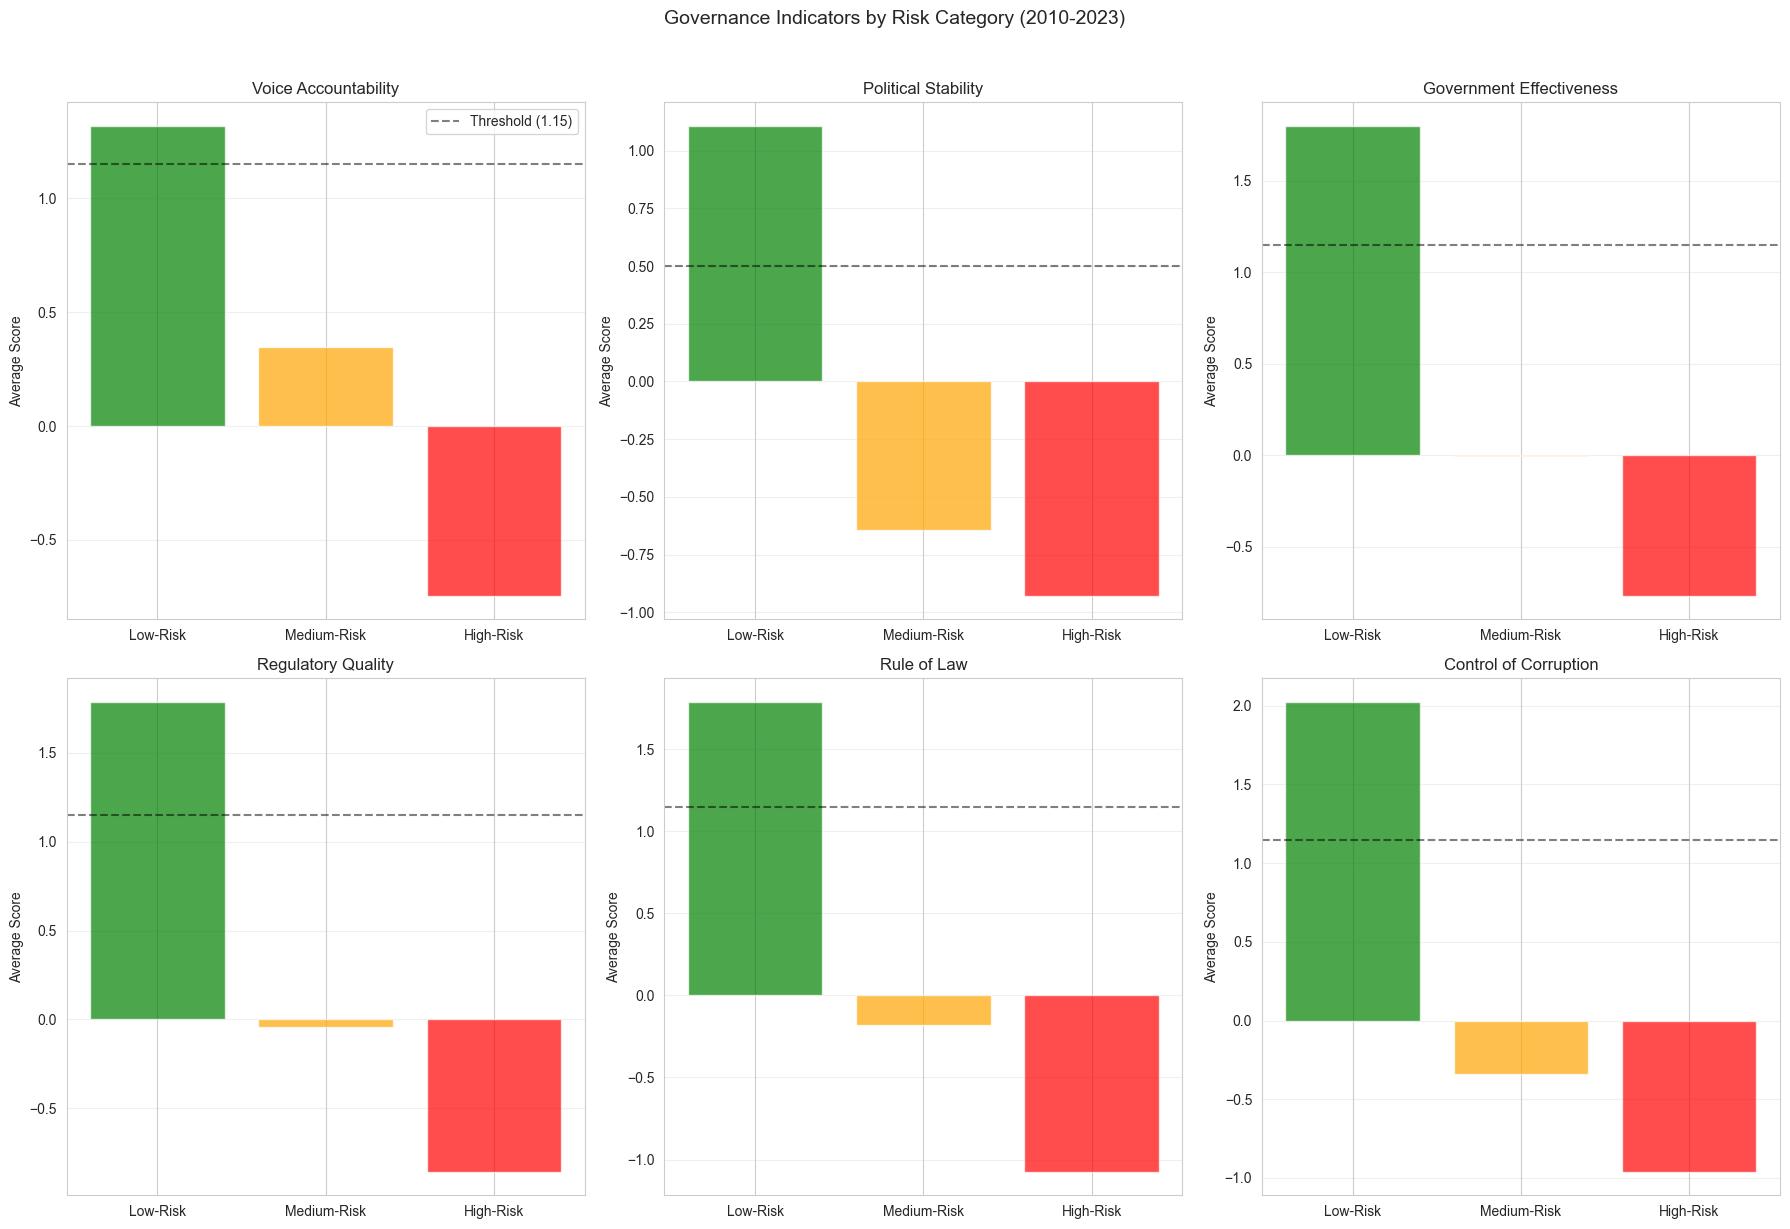

In [86]:
# categorize countries by risk level for visualization
high_risk_list = ['Angola', 'Venezuela', 'Zimbabwe', 'Iraq', 'Ukraine', 'Malaysia', 'Mozambique']
medium_risk_list = ['Brazil', 'South Africa', 'India', 'Philippines']
low_risk_list = ['Norway', 'Denmark', 'Singapore', 'Australia', 'New Zealand', 'Switzerland', 'Germany', 'Canada']

def assign_risk_category(country):
    if country in high_risk_list:
        return 'High-Risk'
    elif country in medium_risk_list:
        return 'Medium-Risk'
    else:
        return 'Low-Risk'

df_expanded['Risk_Category'] = df_expanded['Country'].apply(assign_risk_category)

# plot average governance scores by risk category
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Governance Indicators by Risk Category (2010-2023)', fontsize=14, y=1.02)

indicators = ['Voice_Accountability', 'Political_Stability', 'Government_Effectiveness', 
              'Regulatory_Quality', 'Rule_of_Law', 'Control_of_Corruption']

for idx, indicator in enumerate(indicators):
    ax = axes[idx // 3, idx % 3]
    
    category_means = df_expanded.groupby('Risk_Category')[indicator].mean().sort_values(ascending=False)
    
    colors = {'High-Risk': 'red', 'Medium-Risk': 'orange', 'Low-Risk': 'green'}
    bars = ax.bar(category_means.index, category_means.values, 
                  color=[colors[cat] for cat in category_means.index], alpha=0.7)
    
    if indicator != 'Political_Stability':
        threshold = 1.15
        ax.axhline(y=threshold, color='black', linestyle='--', alpha=0.5, label=f'Threshold ({threshold})')
    else:
        threshold = 0.50
        ax.axhline(y=threshold, color='black', linestyle='--', alpha=0.5, label=f'Threshold ({threshold})')
    
    ax.set_title(indicator.replace('_', ' '), fontsize=12)
    ax.set_ylabel('Average Score')
    ax.grid(True, alpha=0.3, axis='y')
    if idx == 0:
        ax.legend()

plt.tight_layout()
plt.savefig('results/figures/03/expanded_governance_by_risk_category.png', dpi=300, bbox_inches='tight')
plt.show()


### Governance Indicators Heatmap


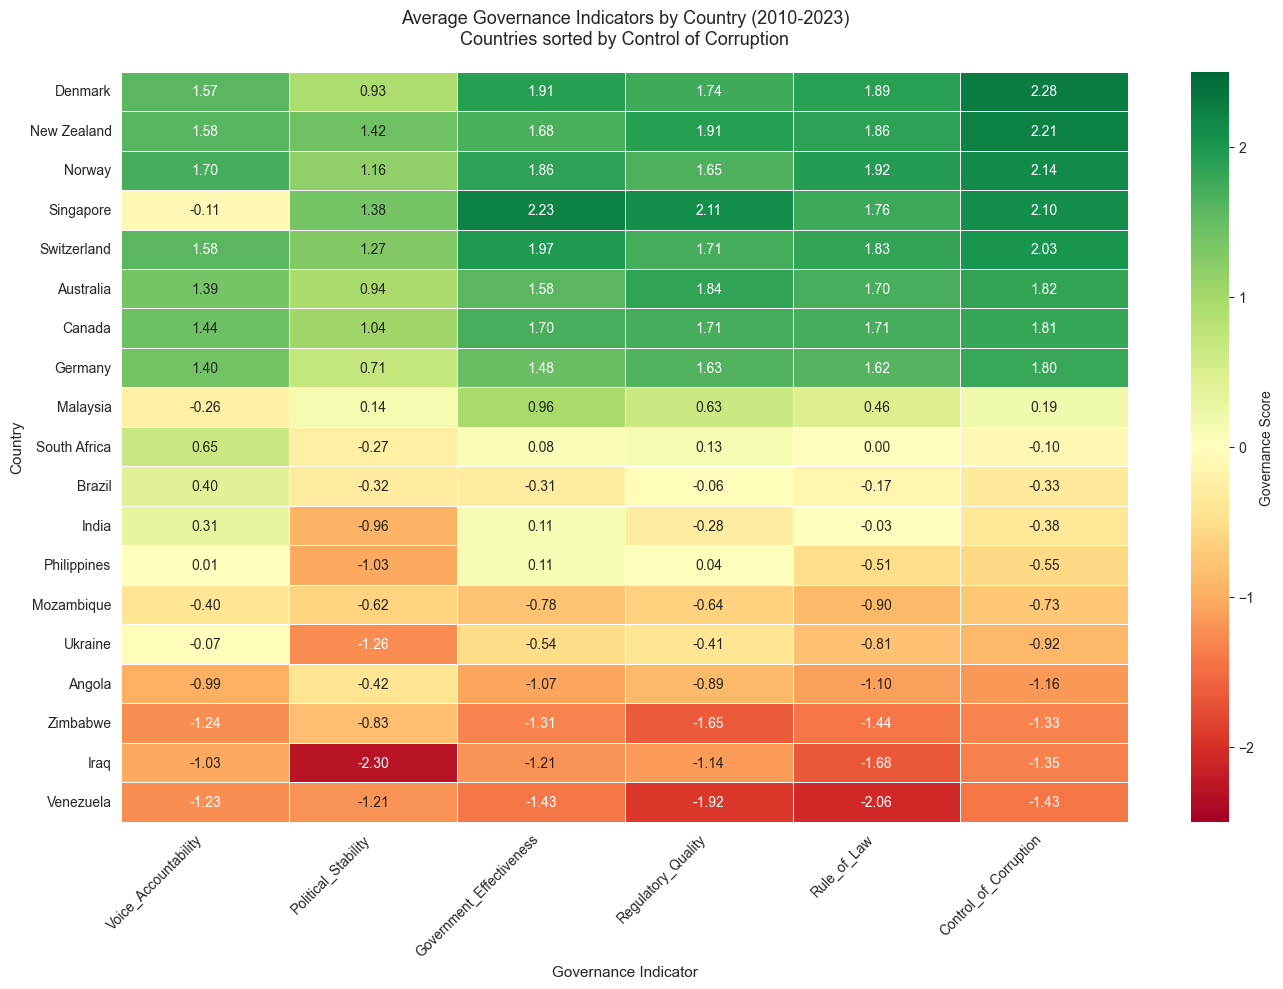

In [87]:
# create heatmap of average governance scores by country
gov_avg = df_expanded.groupby('Country')[indicators].mean()

# sort by Control_of_Corruption (key indicator for corruption risk)
gov_avg_sorted = gov_avg.sort_values('Control_of_Corruption', ascending=False)

plt.figure(figsize=(14, 10))
sns.heatmap(gov_avg_sorted, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            cbar_kws={'label': 'Governance Score'}, linewidths=0.5, vmin=-2.5, vmax=2.5)
plt.title('Average Governance Indicators by Country (2010-2023)\nCountries sorted by Control of Corruption', 
          fontsize=13, pad=20)
plt.xlabel('Governance Indicator', fontsize=11)
plt.ylabel('Country', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('results/figures/03/expanded_governance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


## Corruption Risk Labeling Methodology

The labeling approach operationalizes the theoretical framework's emphasis on governance structures as indicators of corruption vulnerability. We apply threshold-based flags to six World Bank governance indicators that directly measure the structural weaknesses identified in the literature:

1. **Voice & Accountability** (< 1.15): Measures extent of democratic participation and freedom of expression
2. **Political Stability** (< 0.50): Assesses likelihood of government destabilization
3. **Government Effectiveness** (< 1.15): Evaluates quality of public services and policy implementation
4. **Regulatory Quality** (< 1.15): Measures ability to formulate and implement sound policies
5. **Rule of Law** (< 1.15): Assesses extent to which agents have confidence in and abide by rules
6. **Control of Corruption** (< 1.15): Directly measures perceptions of corruption control

Thresholds are set based on empirical distributions and validated against documented corruption cases. A country-year observation is labeled as **high risk (1)** if it flags on 4 or more indicators, reflecting the multi-dimensional nature of governance failure. Otherwise, it is labeled as **low risk (0)**.


In [88]:
# define governance thresholds based on empirical analysis
thresholds = {
    'Voice_Accountability': 1.15,
    'Political_Stability': 0.50,
    'Government_Effectiveness': 1.15,
    'Regulatory_Quality': 1.15,
    'Rule_of_Law': 1.15,
    'Control_of_Corruption': 1.15
}

# create binary flags for each governance indicator
for indicator, threshold in thresholds.items():
    df_expanded[f'{indicator}_flag'] = (df_expanded[indicator] < threshold).astype(int)

# aggregate flags to create risk score
flag_cols = [f'{ind}_flag' for ind in thresholds.keys()]
df_expanded['total_flags'] = df_expanded[flag_cols].sum(axis=1)

# binary risk label: 4+ flags indicates high corruption risk
df_expanded['corruption_risk'] = (df_expanded['total_flags'] >= 4).astype(int)

print("Label distribution:")
print(df_expanded['corruption_risk'].value_counts().sort_index())
print(f"\nHigh risk proportion: {df_expanded['corruption_risk'].mean():.1%}")


Label distribution:
corruption_risk
0    112
1    154
Name: count, dtype: int64

High risk proportion: 57.9%


## Understanding the Medium-Risk Category

Countries were initially categorized into three risk tiers (Low/Medium/High) for exploratory analysis. The machine learning model uses binary labels (0 = Low Risk, 1 = High Risk) based on the "4 of 6 flags" rule applied to each country-year observation.

Countries in the Medium-Risk category (Brazil, India, Philippines, South Africa) consistently trigger 4+ governance flags, resulting in High Risk (1) labels. This reflects that these countries, despite having some stronger institutions than the High-Risk tier, still fall below the governance thresholds for corruption risk detection. The three-tier categorization provides descriptive context, while binary labels maintain a clear decision boundary for model training.


## Validation Against Documented Corruption Cases

The labeling methodology is validated against documented corruption cases that align with the theoretical framework's emphasis on governance failures enabling fund diversion:

1. **Malaysia (2013-2015)**: The 1MDB scandal involved $4.5 billion USD stolen from a state development fund through weak oversight structures.

2. **Mozambique (2013-2016)**: The hidden debt crisis involved $2 billion USD in illicit loans diverted from development purposes, facilitated by governance weaknesses.

3. **Canada**: Serves as a control case with strong governance institutions and no documented major corruption scandals during this period.


In [89]:
# validate malaysia 1mdb period (2013-2015)
df_expanded['Year_numeric'] = pd.to_numeric(df_expanded['Year'], errors='coerce')
malaysia_scandal = df_expanded[(df_expanded['Country'] == 'Malaysia') & (df_expanded['Year_numeric'].between(2013, 2015))]
print("Malaysia 1MDB period (2013-2015):")
print(f"High risk labels: {malaysia_scandal['corruption_risk'].sum()}/{len(malaysia_scandal)}")
print(f"Validation passed: {malaysia_scandal['corruption_risk'].all()}")

# validate mozambique hidden debt period (2013-2016)
mozambique_scandal = df_expanded[(df_expanded['Country'] == 'Mozambique') & (df_expanded['Year_numeric'].between(2013, 2016))]
print("\nMozambique hidden debt period (2013-2016):")
print(f"High risk labels: {mozambique_scandal['corruption_risk'].sum()}/{len(mozambique_scandal)}")
print(f"Validation passed: {mozambique_scandal['corruption_risk'].all()}")

# validate canada control case
canada = df_expanded[df_expanded['Country'] == 'Canada']
print("\nCanada (control case):")
print(f"High risk labels: {canada['corruption_risk'].sum()}/{len(canada)}")
print(f"Low risk proportion: {(canada['corruption_risk'] == 0).mean():.1%}")


Malaysia 1MDB period (2013-2015):
High risk labels: 3/3
Validation passed: True

Mozambique hidden debt period (2013-2016):
High risk labels: 4/4
Validation passed: True

Canada (control case):
High risk labels: 0/14
Low risk proportion: 100.0%


## Corruption Risk Labels Visualization


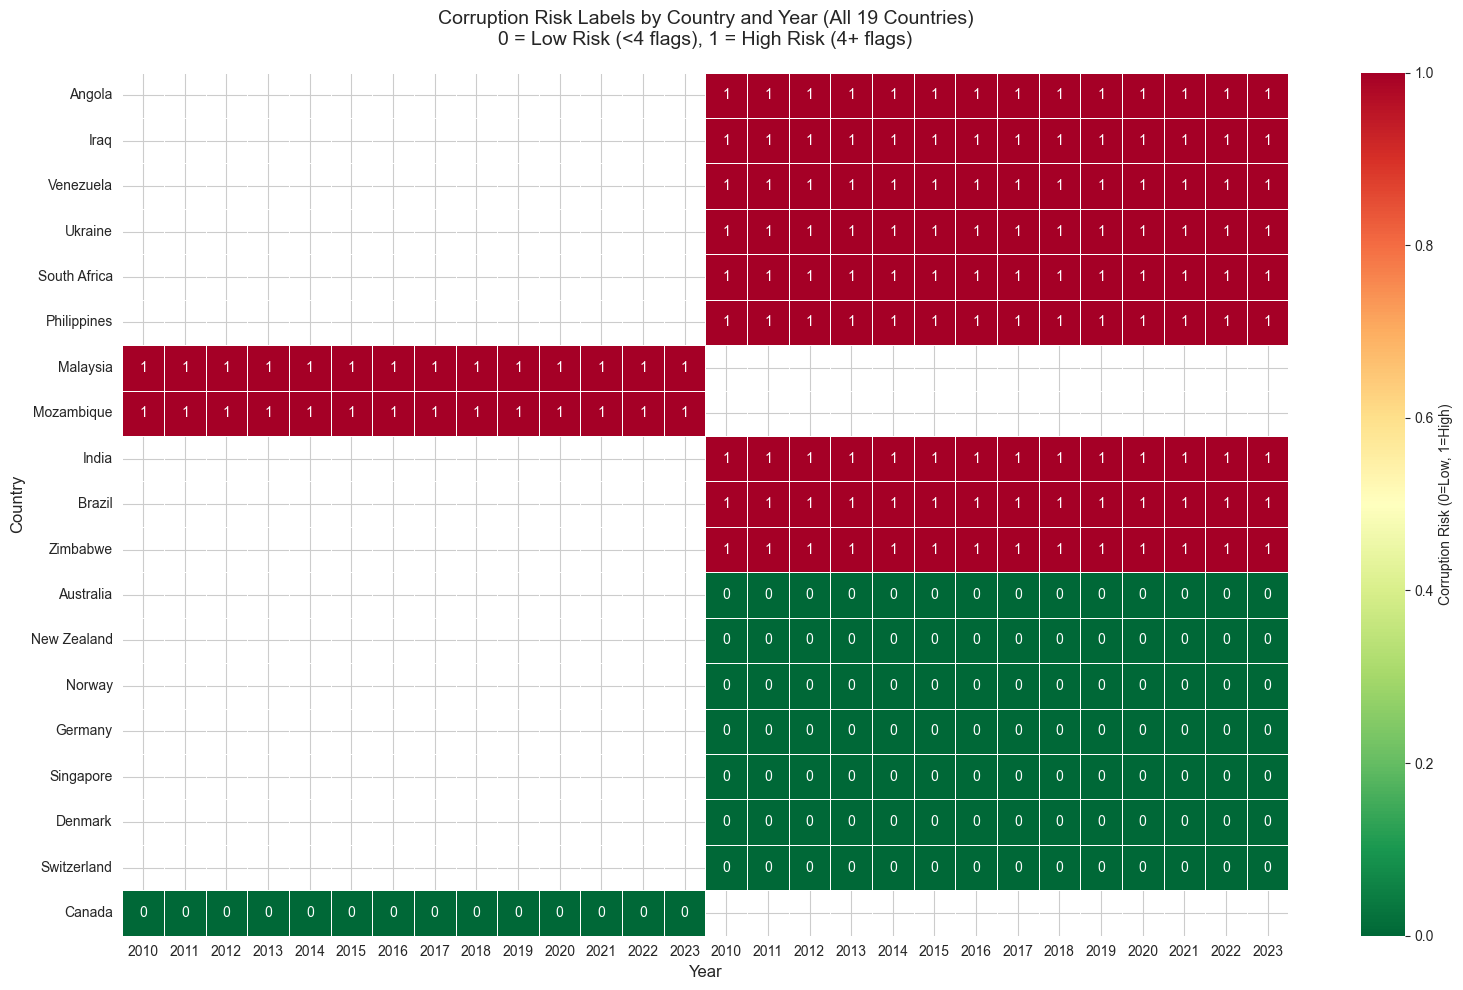

In [90]:
# create heatmap showing corruption risk labels for all 19 countries over time
pivot_risk = df_expanded.pivot_table(index='Country', columns='Year', values='corruption_risk')

# sort by average risk (highest risk at top)
pivot_risk = pivot_risk.loc[pivot_risk.mean(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(16, 10))
sns.heatmap(pivot_risk, annot=True, fmt='.0f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Corruption Risk (0=Low, 1=High)'}, 
            linewidths=0.5, vmin=0, vmax=1)
plt.title('Corruption Risk Labels by Country and Year (All 19 Countries)\n0 = Low Risk (<4 flags), 1 = High Risk (4+ flags)', 
          fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.savefig('results/figures/03/expanded_corruption_risk_labels_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


## Export Processed Dataset

The cleaned and labeled dataset is saved for subsequent model training phases.


In [91]:
# export cleaned dataset for downstream analysis
os.makedirs('data/processed', exist_ok=True)
output_path = 'data/processed/corruption_data_expanded_labeled.csv'
df_expanded.to_csv(output_path, index=False)
print(f"Dataset saved: {output_path}")
print(f"Final dimensions: {df_expanded.shape[0]} observations × {df_expanded.shape[1]} variables")


Dataset saved: data/processed/corruption_data_expanded_labeled.csv
Final dimensions: 266 observations × 23 variables


In [92]:
# final summary
print("\nDataset Summary:")
print(f"  Countries: {df_expanded['Country'].nunique()}")
year_numeric = pd.to_numeric(df_expanded['Year'], errors='coerce')
print(f"  Time period: {int(year_numeric.min())}-{int(year_numeric.max())}")
print(f"  Low risk: {(df_expanded['corruption_risk'] == 0).sum()} observations ({(df_expanded['corruption_risk'] == 0).mean():.1%})")
print(f"  High risk: {(df_expanded['corruption_risk'] == 1).sum()} observations ({(df_expanded['corruption_risk'] == 1).mean():.1%})")
print(f"\nValidation Results:")
print(f"  Malaysia 1MDB period correctly labeled: {malaysia_scandal['corruption_risk'].all()}")
print(f"  Mozambique hidden debt period correctly labeled: {mozambique_scandal['corruption_risk'].all()}")



Dataset Summary:
  Countries: 19
  Time period: 2010-2023
  Low risk: 112 observations (42.1%)
  High risk: 154 observations (57.9%)

Validation Results:
  Malaysia 1MDB period correctly labeled: True
  Mozambique hidden debt period correctly labeled: True
